# Visualize full Amazon Customer Reviews Dataset with Spark and AWS Glue Interactive Sessions

In this notebook, we will query the full reviews data using AWS Glue interactive sessions with PySpark. With [AWS Glue](https://aws.amazon.com/glue/) interactive sessions, you can rapidly build, test, and run data preparation and analytics applications. Interactive sessions provides a programmatic interface for building and testing extract, transform, and load (ETL) scripts for data preparation. This is a powerful tool for data engineers and scientists who are doing interactive development on large datasets which require distributed computing because they do not need to manage infrastructure for Spark clusters.

In the data science lifecycle, exploratory data analysis (EDA) is an important step for data scientists and engineers to gain an intuitive understanding of their datasets. This intuitive understanding then guides decisions which come further in the ML lifecycle like model training, deployment, and monitoring. In this notebook, we will use PySpark and Spark SQL to do EDA and associated visualizations of the Amazon reviews dataset.

**Please Note: if you are running this workshop on your own AWS Account (not an AWS lead workshop), you will need to update your SageMaker execution role IAM permissions via the documentation [here](https://docs.aws.amazon.com/sagemaker/latest/dg/studio-notebooks-glue.html).**

![glue-interactive-sessions](./img/gis.png)

# Dataset Column Descriptions

- `marketplace`: 2-letter country code (in this case all "US").
- `customer_id`: Random identifier that can be used to aggregate reviews written by a single author.
- `review_id`: A unique ID for the review.
- `product_id`: The Amazon Standard Identification Number (ASIN).  `http://www.amazon.com/dp/<ASIN>` links to the product's detail page.
- `product_parent`: The parent of that ASIN.  Multiple ASINs (color or format variations of the same product) can roll up into a single parent.
- `product_title`: Title description of the product.
- `product_category`: Broad product category that can be used to group reviews (in this case digital videos).
- `star_rating`: The review's rating (1 to 5 stars).
- `helpful_votes`: Number of helpful votes for the review.
- `total_votes`: Number of total votes the review received.
- `vine`: Was the review written as part of the [Vine](https://www.amazon.com/gp/vine/help) program?
- `verified_purchase`: Was the review from a verified purchase?
- `review_headline`: The title of the review itself.
- `review_body`: The text of the review.
- `review_date`: The date the review was written.
- `year`: The year derived from the review date.

In [4]:
%stop_session

Welcome to the Glue Interactive Sessions Kernel
For more information on available magic commands, please type %help in any new cell.

Please view our Getting Started page to access the most up-to-date information on the Interactive Sessions kernel: https://docs.aws.amazon.com/glue/latest/dg/interactive-sessions.html
It looks like there is a newer version of the kernel available. The latest version is 0.38.0 and you have 0.37.4 installed.
Please run `pip install --upgrade aws-glue-sessions` to upgrade your kernel
There is no current session.


In [7]:
%additional_python_modules seaborn,psutil
%number_of_workers 10

Additional python modules to be included:
seaborn
psutil
Previous number of workers: 5
Setting new number of workers to: 10


In [1]:
spark

Authenticating with environment variables and user-defined glue_role_arn: arn:aws:iam::183458221001:role/service-role/AmazonSageMaker-ExecutionRole-20230607T184721
Trying to create a Glue session for the kernel.
Worker Type: G.1X
Number of Workers: 10
Session ID: b92dff07-973d-4ce3-9213-260d1205f48c
Job Type: glueetl
Applying the following default arguments:
--glue_kernel_version 0.37.4
--enable-glue-datacatalog true
--additional-python-modules seaborn,psutil
Waiting for session b92dff07-973d-4ce3-9213-260d1205f48c to get into ready status...
Session b92dff07-973d-4ce3-9213-260d1205f48c has been created.


# Set Seaborn Parameters

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

sns.set_style = "seaborn-whitegrid"

sns.set(
    rc={
        "font.style": "normal",
        "axes.facecolor": "white",
        "grid.color": ".8",
        "grid.linestyle": "-",
        "figure.facecolor": "white",
        "figure.titlesize": 20,
        "text.color": "black",
        "xtick.color": "black",
        "ytick.color": "black",
        "axes.labelcolor": "black",
        "axes.grid": True,
        "axes.labelsize": 10,
        "xtick.labelsize": 10,
        "font.size": 10,
        "ytick.labelsize": 10,
    }
)

# Helper Code to Display Values on Bars

In [3]:
def show_values_barplot(axs, space):
    def _show_on_plot(ax):
        for p in ax.patches:
            _x = p.get_x() + p.get_width() + float(space)
            _y = p.get_y() + p.get_height()
            value = round(float(p.get_width()), 2)
            ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_plot(ax)
    else:
        _show_on_plot(axs)

# Set Glue Database and Table names to query

In [4]:
database_name = "default"
table_name = "amazon_reviews_parquet"

# 1. Which Product Categories are Highest Rated by Average Rating?
## _This query takes a minute or two.  Please be patient._

In [5]:
df = spark.sql("""SELECT product_category, AVG(star_rating) AS avg_star_rating 
    FROM {}.{} 
    GROUP BY product_category 
    ORDER BY avg_star_rating DESC""".format(database_name, table_name)
)
df.show(50, truncate=False)

+------------------------+------------------+
|product_category        |avg_star_rating   |
+------------------------+------------------+
|Gift_Card               |4.731363105858364 |
|Digital_Music_Purchase  |4.636945897383845 |
|Music                   |4.440540705473373 |
|Books                   |4.340540167594962 |
|Digital_Ebook_Purchase  |4.312491185831222 |
|Grocery                 |4.3122209651867776|
|Video_DVD               |4.307379993803094 |
|Tools                   |4.26214078611011  |
|Musical_Instruments     |4.251038036164822 |
|Automotive              |4.246242829469048 |
|Shoes                   |4.2414026795449224|
|Outdoors                |4.239963115827751 |
|Sports                  |4.229078730400938 |
|Luggage                 |4.223774961905526 |
|Toys                    |4.218104581238039 |
|Digital_Video_Download  |4.207548770783551 |
|Kitchen                 |4.20729367860571  |
|Video                   |4.20092865030212  |
|Beauty                  |4.187224

In [6]:
# Store number of categories for later
num_categories = df.toPandas().shape[0]

 # Store average star ratings for later
average_star_ratings = df.toPandas()

## Visualization

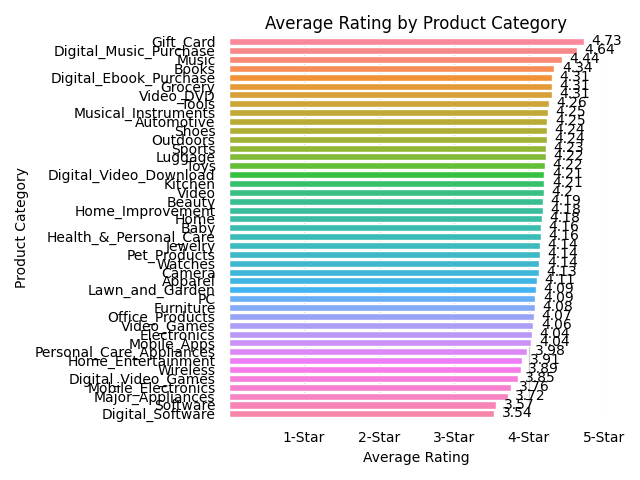

In [7]:
plt.clf()

# Create plot
barplot = sns.barplot(y="product_category", x="avg_star_rating", data=df.toPandas(), saturation=1)

if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# Set title and x-axis ticks
plt.title("Average Rating by Product Category")
plt.xticks([1, 2, 3, 4, 5], ["1-Star", "2-Star", "3-Star", "4-Star", "5-Star"])

# Helper code to show actual values afters bars
show_values_barplot(barplot, 0.1)

plt.xlabel("Average Rating")
plt.ylabel("Product Category")

# Export plot if needed
plt.tight_layout()
# plt.savefig('avg_ratings_per_category.png', dpi=300)

# Show graphic
#plt.show(barplot)
plt.show()

%matplot plt

# 2. Which Product Categories Have the Most Reviews?
## _This query takes a minute or two.  Please be patient._

Note that in this cell, you are using PySpark syntax to process the data in your Glue table while the previous section was using Spark SQL.

In [8]:
from pyspark.sql import functions as f
df_raw = spark.sql("SELECT * FROM {}.{}".format(database_name, table_name))
df = (
    df_raw
    .select("product_category", "star_rating")
    .groupBy("product_category")
    .agg(f.count("star_rating").alias("count_star_rating"))
    .orderBy("count_star_rating", ascending=False)
)

df.show(50, truncate=False)

+------------------------+-----------------+
|product_category        |count_star_rating|
+------------------------+-----------------+
|Books                   |20726160         |
|Digital_Ebook_Purchase  |19180765         |
|Wireless                |9038249          |
|Video_DVD               |7135819          |
|PC                      |7004337          |
|Mobile_Apps             |6807166          |
|Home                    |6228567          |
|Music                   |6177781          |
|Apparel                 |5906460          |
|Health_&_Personal_Care  |5332883          |
|Digital_Video_Download  |5173743          |
|Beauty                  |5115721          |
|Toys                    |4981601          |
|Kitchen                 |4882831          |
|Sports                  |4860054          |
|Shoes                   |4379475          |
|Automotive              |3516476          |
|Electronics             |3120938          |
|Office_Products         |2646491          |
|Pet_Produ

In [9]:
# Store counts for later
count_ratings = df.toPandas()["count_star_rating"]

# Store max ratings for later
max_ratings = df.toPandas()["count_star_rating"].max()

## Visualization

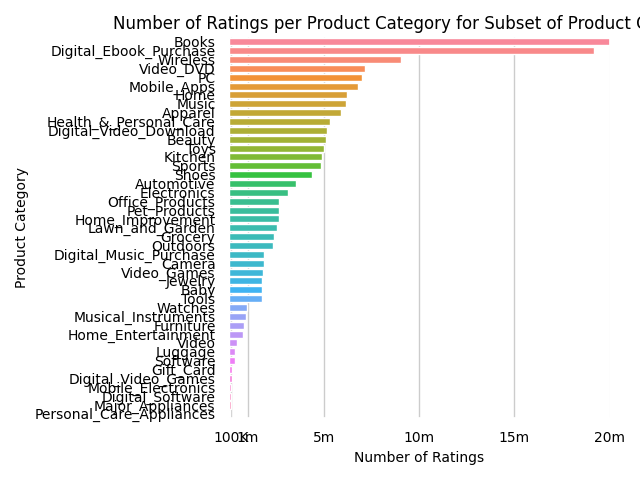

In [10]:
plt.clf()

# Create Seaborn barplot
barplot = sns.barplot(y="product_category", x="count_star_rating", data=df.toPandas(), saturation=1)

if num_categories < 10:
    sns.set(rc={"figure.figsize": (10.0, 5.0)})

# Set title
plt.title("Number of Ratings per Product Category for Subset of Product Categories")

# Set x-axis ticks to match scale
if max_ratings > 200000:
    plt.xticks([100000, 1000000, 5000000, 10000000, 15000000, 20000000], ["100K", "1m", "5m", "10m", "15m", "20m"])
    plt.xlim(0, 20000000)
elif max_ratings <= 200000:
    plt.xticks([50000, 100000, 150000, 200000], ["50K", "100K", "150K", "200K"])
    plt.xlim(0, 200000)

plt.xlabel("Number of Ratings")
plt.ylabel("Product Category")

plt.tight_layout()

# Export plot if needed
# plt.savefig('ratings_per_category.png', dpi=300)

# Show the barplot
plt.show()

%matplot plt

# 3. When did each product category become available in the Amazon catalog based on the date of the first review?
## _This query takes a minute or two.  Please be patient._

In [11]:
# SQL statement
df = spark.sql("""
    SELECT product_category, MIN(year) AS first_review_year
    FROM {}.{}
    WHERE year >= 1995
    GROUP BY product_category
    ORDER BY first_review_year 
""".format(database_name, table_name)
)

df.show(50, truncate=False)

+------------------------+-----------------+
|product_category        |first_review_year|
+------------------------+-----------------+
|Video                   |1995             |
|Books                   |1995             |
|Music                   |1995             |
|Video_DVD               |1996             |
|Toys                    |1997             |
|Sports                  |1997             |
|Video_Games             |1997             |
|Software                |1998             |
|Wireless                |1998             |
|Home                    |1998             |
|Camera                  |1998             |
|Office_Products         |1998             |
|Home_Entertainment      |1998             |
|Pet_Products            |1998             |
|Musical_Instruments     |1999             |
|PC                      |1999             |
|Electronics             |1999             |
|Baby                    |1999             |
|Health_&_Personal_Care  |1999             |
|Home_Impr

In [12]:
def get_x_y(df):
    """ Get X and Y coordinates; return tuple """
    series = df["first_review_year"].value_counts().sort_index()
    # new_series = series.reindex(range(1,21)).fillna(0).astype(int)
    return series.index, series.values

In [13]:
X, Y = get_x_y(df.toPandas())
print(X)
print(Y)

Int64Index([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2004, 2006, 2008,
            2010],
           dtype='int64')
[ 3  1  3  7 13  8  3  1  1  1  1  1]


## Visualization

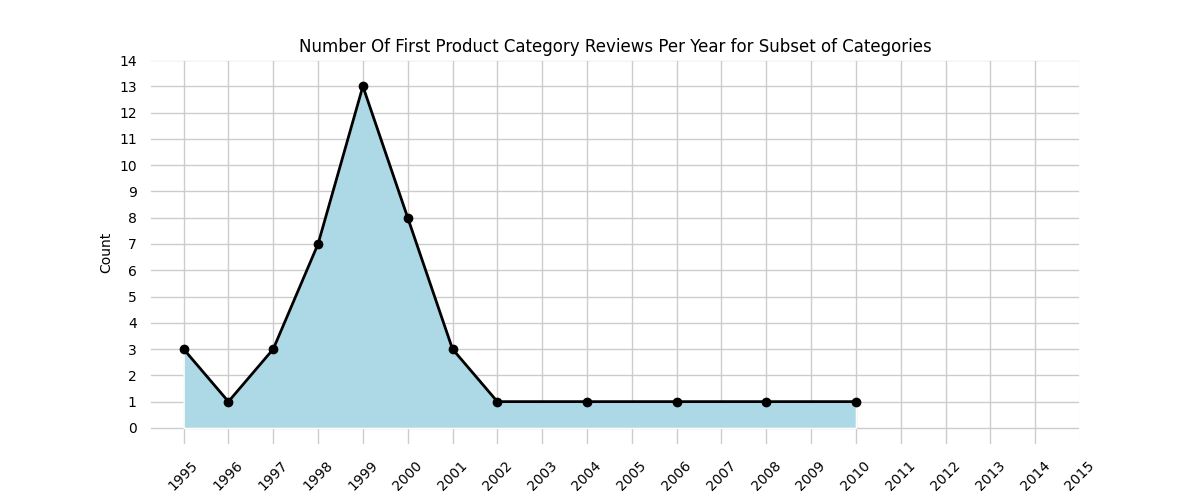

In [14]:
plt.clf()

fig = plt.figure(figsize=(12, 5))
ax = plt.gca()

ax.set_title("Number Of First Product Category Reviews Per Year for Subset of Categories")
ax.set_xlabel("Year")
ax.set_ylabel("Count")


ax.plot(X, Y, color="black", linewidth=2, marker="o")
ax.fill_between(X, [0] * len(X), Y, facecolor="lightblue")

ax.locator_params(integer=True)

ax.set_xticks(range(1995, 2016, 1))
ax.set_yticks(range(0, max(Y) + 2, 1))

plt.xticks(rotation=45)

# fig.savefig('first_reviews_per_year.png', dpi=300)
plt.show()

%matplot plt

# 4. What is the breakdown of ratings (1-5) per product category?
## _This query takes a minute or two.  Please be patient._


In [15]:
# SQL statement
df = spark.sql("""
    SELECT product_category, star_rating, COUNT(*) AS count_reviews
    FROM {}.{}
    GROUP BY  product_category, star_rating
    ORDER BY  product_category ASC, star_rating DESC, count_reviews
""".format(database_name, table_name)
)

df.show(50, truncate=False)

+----------------------+-----------+-------------+
|product_category      |star_rating|count_reviews|
+----------------------+-----------+-------------+
|Apparel               |5          |3320651      |
|Apparel               |4          |1147254      |
|Apparel               |3          |623483       |
|Apparel               |2          |369608       |
|Apparel               |1          |445464       |
|Automotive            |5          |2301688      |
|Automotive            |4          |526898       |
|Automotive            |3          |240023       |
|Automotive            |2          |147843       |
|Automotive            |1          |300024       |
|Baby                  |5          |1078545      |
|Baby                  |4          |289129       |
|Baby                  |3          |150753       |
|Baby                  |2          |101427       |
|Baby                  |1          |145039       |
|Beauty                |5          |3254946      |
|Beauty                |4      

## Prepare for Stacked Percentage Horizontal Bar Plot Showing Proportion of Star Ratings per Product Category

In [16]:
# Create grouped DataFrames by category and by star rating
grouped_category = df.toPandas().groupby("product_category")
grouped_star = df.toPandas().groupby("star_rating")

# Create sum of ratings per star rating
df_sum = df.toPandas().groupby(["star_rating"]).sum()

# Calculate total number of star ratings
total = df_sum["count_reviews"].sum()
print(total)

160796570


In [17]:
# Create dictionary of product categories and array of star rating distribution per category
distribution = {}
count_reviews_per_star = []
i = 0

for category, ratings in grouped_category:
    count_reviews_per_star = []
    for star in ratings["star_rating"]:
        count_reviews_per_star.append(ratings.at[i, "count_reviews"])
        i = i + 1
    distribution[category] = count_reviews_per_star

# Check if distribution has been created succesfully
print(distribution)

{'Apparel': [3320651, 1147254, 623483, 369608, 445464], 'Automotive': [2301688, 526898, 240023, 147843, 300024], 'Baby': [1078545, 289129, 150753, 101427, 145039], 'Beauty': [3254946, 741443, 398405, 264029, 456898], 'Books': [13662131, 3546319, 1543611, 861867, 1112232], 'Camera': [1085596, 344163, 144596, 92396, 172009], 'Digital_Ebook_Purchase': [11612150, 4311745, 1701301, 749678, 805891], 'Digital_Music_Purchase': [1467877, 231676, 70507, 28743, 53381], 'Digital_Software': [46410, 16693, 8308, 6890, 23783], 'Digital_Video_Download': [3122980, 984221, 449260, 251930, 365352], 'Digital_Video_Games': [80677, 20406, 11629, 7749, 24970], 'Electronics': [1796672, 542181, 240859, 180668, 360558], 'Furniture': [447763, 153678, 73574, 43853, 73346], 'Gift_Card': [129709, 9859, 3156, 1569, 4793], 'Grocery': [1662278, 293389, 161497, 105265, 180049], 'Health_&_Personal_Care': [3359016, 782025, 400572, 278066, 513204], 'Home': [3897623, 960326, 500884, 324345, 545389], 'Home_Entertainment': [

In [18]:
# Sort distribution by average rating per category
sorted_distribution = {}

average_star_ratings.iloc[:, 0]
for index, value in average_star_ratings.iloc[:, 0].items():
    sorted_distribution[value] = distribution[value]

In [19]:
df_sorted_distribution_pct = pd.DataFrame(sorted_distribution).transpose().apply(
    lambda num_ratings: num_ratings/sum(num_ratings)*100, axis=1
)
df_sorted_distribution_pct.columns=['5', '4', '3', '2', '1']
df_sorted_distribution_pct

                                  5          4          3         2          1
Gift_Card                 87.002804   6.612962   2.116899  1.052413   3.214923
Digital_Music_Purchase    79.251144  12.508261   3.806695  1.551844   2.882057
Music                     69.539775  16.494078   6.564509  3.283720   4.117919
Books                     65.917329  17.110352   7.447646  4.158354   5.366320
Digital_Ebook_Purchase    60.540599  22.479526   8.869829  3.908489   4.201558
Grocery                   69.190145  12.211933   6.722101  4.381518   7.494304
Video_DVD                 65.894034  15.950152   7.575739  4.159929   6.420146
Tools                     63.955084  17.205723   7.242152  4.292266   7.304774
Musical_Instruments       63.294628  17.553808   7.410541  4.442784   7.298239
Automotive                65.454392  14.983694   6.825669  4.204294   8.531951
Shoes                     60.454370  19.419040   9.253689  5.558292   5.314610
Outdoors                  62.319548  18.134270   7.7

## Visualization

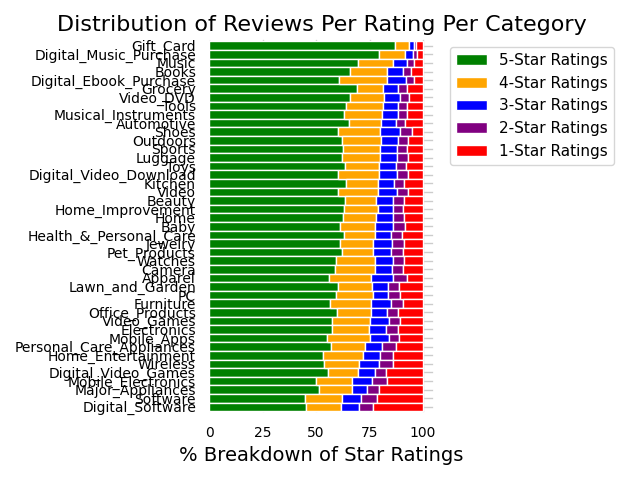

In [20]:
plt.clf()

categories = df_sorted_distribution_pct.index

# Plot bars
if len(categories) > 10:
    plt.figure(figsize=(10,10))
else: 
    plt.figure(figsize=(10,5))

df_sorted_distribution_pct.plot(kind="barh", 
                                stacked=True, 
                                edgecolor='white',
                                width=1.0,
                                color=['green', 
                                       'orange', 
                                       'blue', 
                                       'purple', 
                                       'red'])

plt.title("Distribution of Reviews Per Rating Per Category", 
          fontsize='16')

plt.legend(bbox_to_anchor=(1.04,1), 
           loc="upper left",
           labels=['5-Star Ratings', 
                   '4-Star Ratings', 
                   '3-Star Ratings', 
                   '2-Star Ratings', 
                   '1-Star Ratings'])

plt.xlabel("% Breakdown of Star Ratings", fontsize='14')
plt.gca().invert_yaxis()
plt.tight_layout()

plt.show()

%matplot plt

# 5. How Many Reviews per Star Rating? (5, 4, 3, 2, 1)
## _This query takes a minute or two.  Please be patient._

In [21]:
# SQL statement
df = spark.sql("""
    SELECT star_rating, COUNT(*) AS count_reviews
    FROM {}.{}
    GROUP BY star_rating
    ORDER BY star_rating DESC, count_reviews 
""".format(database_name, table_name)
)

df.show()

+-----------+-------------+
|star_rating|count_reviews|
+-----------+-------------+
|          5|     99530924|
|          4|     27996469|
|          3|     12900929|
|          2|      7700647|
|          1|     12667601|
+-----------+-------------+


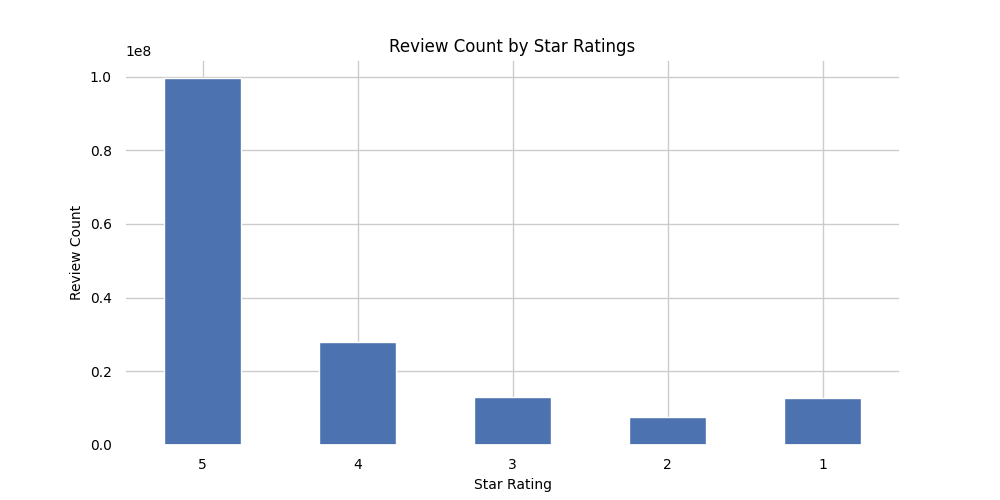

In [22]:
plt.clf()

chart = df.toPandas().plot.bar(
    x="star_rating", y="count_reviews", rot="0", figsize=(10, 5), title="Review Count by Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Review Count")

plt.show()

%matplot plt

# 6. How Did Star Ratings Change Over Time?
Is there a drop-off point for certain product categories throughout the year?

## Average Star Rating Across All Product Categories
## _This query takes a minute or two.  Please be patient._

In [23]:
# SQL statement
df = spark.sql("""
    SELECT year, ROUND(AVG(star_rating),4) AS avg_rating
    FROM {}.{}
    WHERE year >= 1995
    GROUP BY year
    ORDER BY year
""".format(database_name, table_name)
)

df.show(50, truncate=False)

+----+----------+
|year|avg_rating|
+----+----------+
|1995|4.6204    |
|1996|4.6111    |
|1997|4.4348    |
|1998|4.361     |
|1999|4.2886    |
|2000|4.2629    |
|2001|4.2037    |
|2002|4.1698    |
|2003|4.128     |
|2004|4.0695    |
|2005|4.0734    |
|2006|4.1061    |
|2007|4.1733    |
|2008|4.1312    |
|2009|4.1171    |
|2010|4.076     |
|2011|4.0571    |
|2012|4.1271    |
|2013|4.2077    |
|2014|4.2358    |
|2015|4.2549    |
+----+----------+


In [24]:
df.toPandas()["year"] = pd.to_datetime(df.toPandas()["year"], format="%Y").dt.year

## Visualization

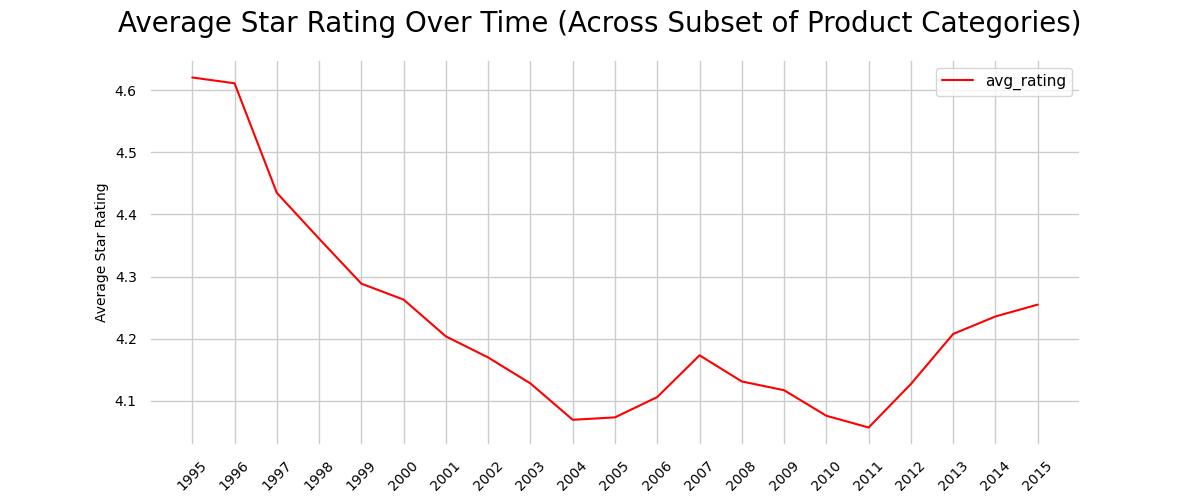

In [25]:
plt.clf()

fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time (Across Subset of Product Categories)")

ax = plt.gca()
# ax = plt.gca().set_xticks(df['year'])
ax.locator_params(integer=True)
ax.set_xticks(df.toPandas()["year"].unique())

df.toPandas().plot(kind="line", x="year", y="avg_rating", color="red", ax=ax)

# plt.xticks(range(1995, 2016, 1))
# plt.yticks(range(0,6,1))
plt.xlabel("Years")
plt.ylabel("Average Star Rating")
plt.xticks(rotation=45)

# fig.savefig('average-rating.png', dpi=300)
plt.show()

%matplot plt

## Average Star Rating Per Product Categories Across Time
## _This query takes a minute or two.  Please be patient._

In [26]:
# SQL statement
df = spark.sql("""
    SELECT product_category, year, ROUND(AVG(star_rating), 4) AS avg_rating_category
    FROM {}.{}
    WHERE year >= 1995
    GROUP BY product_category, year
    ORDER BY year 
""".format(database_name, table_name)
)

df.show(50, truncate=False)

+----------------------+----+-------------------+
|product_category      |year|avg_rating_category|
+----------------------+----+-------------------+
|Music                 |1995|5.0                |
|Books                 |1995|4.6114             |
|Video                 |1995|5.0                |
|Video                 |1996|3.8333             |
|Books                 |1996|4.6135             |
|Music                 |1996|4.6                |
|Video_DVD             |1996|4.0                |
|Sports                |1997|4.0                |
|Toys                  |1997|4.0                |
|Books                 |1997|4.4341             |
|Music                 |1997|4.6794             |
|Video_DVD             |1997|4.6667             |
|Video_Games           |1997|3.5                |
|Video                 |1997|4.4697             |
|Books                 |1998|4.3014             |
|Home_Entertainment    |1998|5.0                |
|Video_Games           |1998|4.3077             |


## Visualization

In [27]:
def plot_categories(df):
    df_categories = df["product_category"].unique()
    for category in df_categories:
        # print(category)
        df_plot = df.loc[df["product_category"] == category]
        df_plot.plot(
            kind="line",
            x="year",
            y="avg_rating_category",
            c=np.random.rand(
                3,
            ),
            ax=ax,
            label=category,
        )

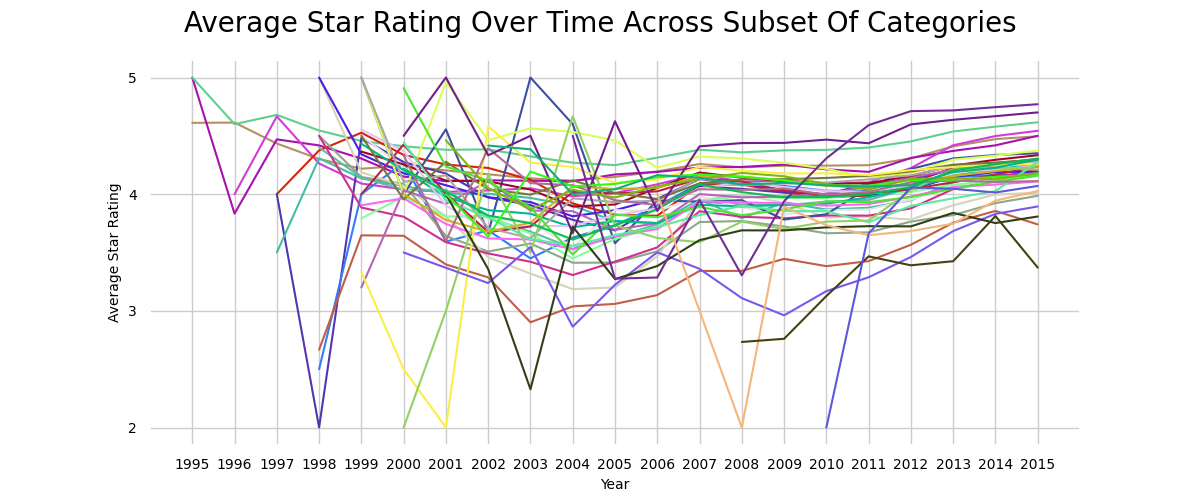

In [28]:
plt.clf()

fig = plt.gcf()
fig.set_size_inches(12, 5)

fig.suptitle("Average Star Rating Over Time Across Subset Of Categories")

ax = plt.gca()

ax.locator_params(integer=True)
ax.set_xticks(df.toPandas()["year"].unique())

plot_categories(df.toPandas())

plt.xlabel("Year")
plt.ylabel("Average Star Rating")
plt.legend(bbox_to_anchor=(0, -0.15, 1, 0), loc=2, ncol=2, mode="expand", borderaxespad=0)

# fig.savefig('average_rating_category_all_data.png', dpi=300)
plt.show()

%matplot plt

# 7. Which Star Ratings (1-5) are Most Helpful?
## _This query takes a minute or two.  Please be patient._

In [29]:
# SQL statement
df = spark.sql("""
    SELECT star_rating, AVG(helpful_votes) AS avg_helpful_votes
    FROM {}.{}
    GROUP BY  star_rating
    ORDER BY  star_rating ASC
""".format(database_name, table_name)
)

df.show()

+-----------+------------------+
|star_rating| avg_helpful_votes|
+-----------+------------------+
|          1| 3.832321447446916|
|          2| 2.570054308423695|
|          3|2.0687386156454313|
|          4|1.6800495805381743|
|          5|1.6912020931303722|
+-----------+------------------+


## Visualization

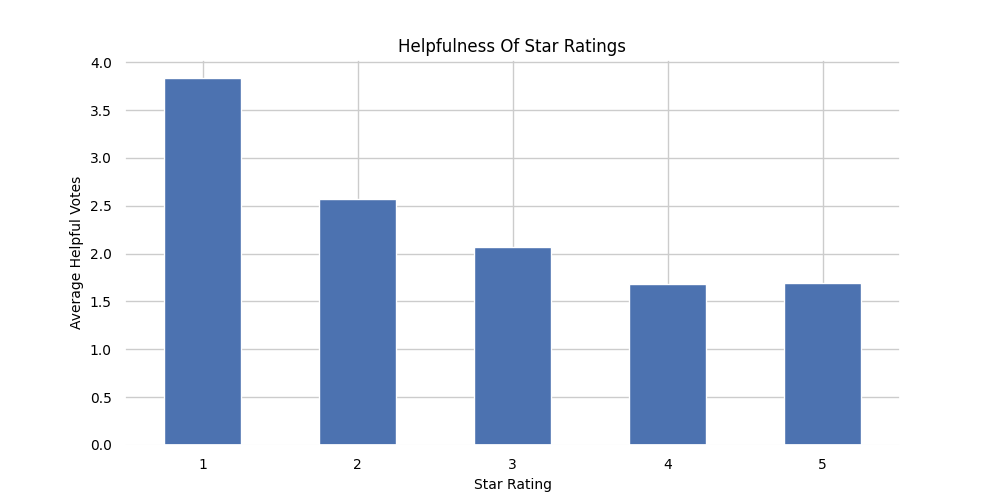

In [30]:
plt.clf()

chart = df.toPandas().plot.bar(
    x="star_rating", y="avg_helpful_votes", rot="0", figsize=(10, 5), title="Helpfulness Of Star Ratings", legend=False
)

plt.xlabel("Star Rating")
plt.ylabel("Average Helpful Votes")

plt.show()

%matplot plt

# 8. Which Products have Most Helpful Reviews?  How Long are the Most Helpful Reviews?
## _This query takes a minute or two.  Please be patient._

In [31]:
# SQL statement
df = spark.sql("""
    SELECT product_title, helpful_votes, star_rating,
           LENGTH(review_body) AS review_body_length,
           SUBSTR(review_body, 1, 100) AS review_body_substr
    FROM {}.{}
    ORDER BY helpful_votes DESC LIMIT 10 
""".format(database_name, table_name)
)

df.show(50, truncate=False)

+----------------------------------------------------------------------------------------+-------------+-----------+------------------+----------------------------------------------------------------------------------------------------+
|product_title                                                                           |helpful_votes|star_rating|review_body_length|review_body_substr                                                                                  |
+----------------------------------------------------------------------------------------+-------------+-----------+------------------+----------------------------------------------------------------------------------------------------+
|Kindle: Amazon's Original Wireless Reading Device (1st generation)                      |47524        |5          |12906             |This is less a \\"pros and cons\\" review than a hopefully useful commentary about the Kindle compar|
|BIC Cristal For Her Ball Pen, 1.0mm, Black, 16ct (M

# 9. What is the Ratio of Positive (5, 4) to Negative (3, 2 ,1) Reviews?
## _This query takes a minute or two.  Please be patient._

In [32]:
# SQL statement
df = spark.sql("""
    SELECT (CAST(positive_review_count AS DOUBLE) / CAST(negative_review_count AS DOUBLE)) AS positive_to_negative_sentiment_ratio
    FROM (
      SELECT count(*) AS positive_review_count
      FROM {}.{}
      WHERE star_rating >= 4

    ), (
      SELECT count(*) AS negative_review_count
      FROM {}.{}
      WHERE star_rating < 4 
    )
""".format(database_name, table_name, database_name, table_name)
)

df.show()

+------------------------------------+
|positive_to_negative_sentiment_ratio|
+------------------------------------+
|                  3.8331995107663768|
+------------------------------------+


# 10. Which Customers are Abusing the Review System by Repeatedly Reviewing the Same Product?  What Was Their Average Star Rating for Each Product?
## _This query takes a minute or two.  Please be patient._

In [ ]:
# SQL statement
df = spark.sql("""
    SELECT customer_id, product_category, product_title, 
    ROUND(AVG(star_rating),4) AS avg_star_rating, COUNT(*) AS review_count 
    FROM {}.{} 
    GROUP BY customer_id, product_category, product_title 
    HAVING COUNT(*) > 1 
    ORDER BY review_count DESC
    LIMIT 50
""".format(database_name, table_name)
)

df.show(50, truncate=False)

In [ ]:
%stop_session

# Conclusions

Through this notebook, we have seen how you can use AWS Glue interactive sessions in SageMaker Studio to process large datasets at scale for ETL and EDA tasks. Benefits of this development paradigm include...

1. natively distributed processing which can scale with your datasets 
2. no need to manage cluster infrastructure
3. integration with SageMaker studio for a one stop shop for the ML lifecycle